<a href="https://colab.research.google.com/github/Aleena24/srgan_cloud/blob/main/srgan_cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing from kaggle using kaggle api


In [1]:
from google.colab import files
files.upload()  # Upload your Kaggle API key (kaggle.json)

# Move the Kaggle API key to the appropriate directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install the Kaggle package if not already installed
!pip install kaggle

# Download the dataset
!kaggle datasets download -d apollo2506/eurosat-dataset

# Unzip the dataset
!unzip eurosat-dataset.zip -d ./EuroSat


Streaming output truncated to the last 5000 lines.
  inflating: ./EuroSat/EuroSATallBands/River/River_1990.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1991.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1992.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1993.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1994.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1995.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1996.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1997.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1998.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1999.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_2.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_20.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_200.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_2000.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_2001.tif  
  inflating: ./EuroSat/Eu

In [2]:
!pip install highlight_text
!pip install perlin_noise
!pip install noise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp310-cp310-linux_x86_64.whl size=56275 sha256=bf6b59d88f124956cd7787773c8cf4dc65bc05da3747b382369c2fd754b8cb3e
  Stored in directory: /root/.cache/pip/wheels/b2/01/64/ca2f6ed556c204d5ce2d3719a58757a5504aeb5525654692d0
Successfully built noise


# Image Preparation

Streaming output truncated to the last 5000 lines.
Processed 22001/27000
Processed 22002/27000
Processed 22003/27000
Processed 22004/27000
Processed 22005/27000
Processed 22006/27000
Processed 22007/27000
Processed 22008/27000
Processed 22009/27000
Processed 22010/27000
Processed 22011/27000
Processed 22012/27000
Processed 22013/27000
Processed 22014/27000
Processed 22015/27000
Processed 22016/27000
Processed 22017/27000
Processed 22018/27000
Processed 22019/27000
Processed 22020/27000
Processed 22021/27000
Processed 22022/27000
Processed 22023/27000
Processed 22024/27000
Processed 22025/27000
Processed 22026/27000
Processed 22027/27000
Processed 22028/27000
Processed 22029/27000
Processed 22030/27000
Processed 22031/27000
Processed 22032/27000
Processed 22033/27000
Processed 22034/27000
Processed 22035/27000
Processed 22036/27000
Processed 22037/27000
Processed 22038/27000
Processed 22039/27000
Processed 22040/27000
Processed 22041/27000
Processed 22042/27000
Processed 22043/27000
Pro

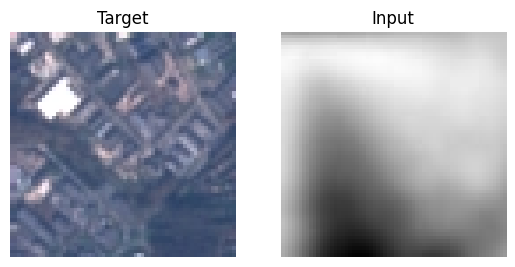

In [3]:
import numpy as np
import pandas as pd
import random
from os import listdir, mkdir, rename
from os.path import join, exists
import shutil
import datetime
import matplotlib.pyplot as plt
from highlight_text import ax_text, fig_text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from perlin_noise import PerlinNoise
from noise import pnoise2

# Image preparation
classes = listdir('./EuroSat/EuroSAT')
path_target = './EuroSat/all_targets'
path_input = './EuroSat/all_inputs'

# Create directories if they do not exist
if not exists(path_input):
    mkdir(path_input)
if not exists(path_target):
    mkdir(path_target)

k = 1
for kind in classes:
    path = join('./EuroSat/EuroSAT', str(kind))
    try:
        files = listdir(path)
    except NotADirectoryError:
        continue  # Skip this iteration if path is not a directory

    for i, f in enumerate(files):
        if f.endswith('.jpg') or f.endswith('.png'):  # Filter only image files
            shutil.copyfile(join(path, f), join(path_target, f))
            rename(join(path_target, f), join(path_target, f'{k}.jpg'))
            k += 1

def generate_perlin_noise(width, height, scale, octaves, persistence, lacunarity):
    noise = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            noise[i][j] = pnoise2(i / scale,
                                  j / scale,
                                  octaves=octaves,
                                  persistence=persistence,
                                  lacunarity=lacunarity,
                                  repeatx=width,
                                  repeaty=height,
                                  base=0)
    return noise

def normalize_noise(noise):
    min_val = noise.min()
    max_val = noise.max()
    return (noise - min_val) / (max_val - min_val)

def generate_clouds(width, height, base_scale, octaves, persistence, lacunarity):
    clouds = np.zeros((height, width))
    for octave in range(1, octaves + 1):
        scale = base_scale / octave
        layer = generate_perlin_noise(width, height, scale, 1, persistence, lacunarity)
        clouds += layer * (persistence ** octave)

    clouds = normalize_noise(clouds)
    return clouds

def overlay_clouds(image, clouds, alpha=0.5):
    clouds_rgb = np.stack([clouds] * 3, axis=-1)
    image = image.astype(float) / 255.0
    clouds_rgb = clouds_rgb.astype(float)
    blended = image * (1 - alpha) + clouds_rgb * alpha
    blended = (blended * 255).astype(np.uint8)
    return blended

width, height = 64, 64
octaves = 12  # number of noise layers combined
persistence = 0.5  # lower persistence reduces the amplitude of higher-frequency octaves
lacunarity = 2  # higher lacunarity increases the frequency of higher-frequency octaves

for i in range(len(listdir(path_target))):
    base_scale = random.uniform(5, 120)  # noise frequency
    alpha = random.uniform(0, 1)  # transparency

    clouds = generate_clouds(width, height, base_scale, octaves, persistence, lacunarity)
    img = np.asarray(Image.open(join(path_target, f'{i+1}.jpg')))
    image = Image.fromarray(overlay_clouds(img, clouds, alpha))
    image.save(join(path_input, f'{i+1}.jpg'))
    print(f'Processed {i+1}/{len(listdir(path_target))}')

# Display a random image pair
idx = np.random.randint(len(listdir(path_target)))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.asarray(Image.open(join(path_target, f'{idx}.jpg'))))
ax[1].imshow(np.asarray(Image.open(join(path_input, f'{idx}.jpg'))))
ax[0].set_title("Target")
ax[0].axis('off')
ax[1].set_title("Input")
ax[1].axis('off')
plt.show()


# Data Loader

In [4]:
import os
import shutil
from tqdm import tqdm
import random

# Assuming the dataset is already extracted into './EuroSat/' directory
dataset_dir = './EuroSat/'

# Creating directories for input and target images
path_target = './EuroSat/all_targets/'
path_input = './EuroSat/all_inputs/'
if not os.path.exists(path_target):
    os.makedirs(path_target)
if not os.path.exists(path_input):
    os.makedirs(path_input)

# Move images to respective directories
classes = os.listdir(os.path.join(dataset_dir, 'EuroSAT'))
for kind in classes:
    path = os.path.join(dataset_dir, 'EuroSAT', kind)
    if os.path.isdir(path):  # Check if 'path' is a directory
        for i, f in enumerate(tqdm(os.listdir(path), desc=f'Moving {kind} images')):
            source_file = os.path.join(path, f)
            if os.path.isfile(source_file) and (f.endswith('.jpg') or f.endswith('.png')):
                shutil.copyfile(source_file, os.path.join(path_target if random.random() > 0.5 else path_input, f'{i + 1}.jpg'))


Moving Pasture images: 100%|██████████| 2000/2000 [00:00<00:00, 5089.95it/s]


# Normalization

In [7]:
class CloudDataset(Dataset):
    def __init__(self, images_paths, targets, transform=None):
        self.images_paths = images_paths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        img = Image.open(self.images_paths[idx]).convert('RGB')
        target = Image.open(self.targets[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
            target = self.transform(target)
        return img, target

def get_mean_std(loader):
    num_pixels = 0
    mean_img, std_img = 0.0, 0.0
    mean_target, std_target = 0.0, 0.0
    for images, targets in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean_img += images.mean(axis=(0, 2, 3)).sum()
        std_img += images.std(axis=(0, 2, 3)).sum()
        mean_target += targets.mean(axis=(0, 2, 3)).sum()
        std_target += targets.std(axis=(0, 2, 3)).sum()

    mean_img /= num_pixels
    mean_target /= num_pixels
    std_img /= num_pixels
    std_target /= num_pixels

    return mean_img, mean_target, std_img, std_target

# Define paths to your images and targets
path_input = './EuroSat/all_inputs/'
path_target = './EuroSat/all_targets/'

# Dummy paths for example (replace with actual paths)
images_paths = [path_input + f'{i}.jpg' for i in range(1, 1001)]
targets = [path_target + f'{i}.jpg' for i in range(1, 1001)]

# Example data_transforms for resizing and converting to tensor
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create dataset and DataLoader
train_dataset = CloudDataset(images_paths, targets, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Calculate mean and std
mean_img, mean_target, std_img, std_target = get_mean_std(train_loader)
print(f"Mean Image: {mean_img}, Std Image: {std_img}")
print(f"Mean Target: {mean_target}, Std Target: {std_target}")


Mean Image: 8.936700623962679e-07, Std Image: 3.185420780482673e-07
Mean Target: 6.990699716880044e-07, Std Target: 2.3254058589827764e-07


# Building Generator

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Define the DoubleConv module
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Define the UNet architecture
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.conv_1 = DoubleConv(in_channels, 32)  # Input size: 64x64x64
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: 32x32x32

        self.conv_2 = DoubleConv(32, 64)  # Input size: 32x32x32
        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: 16x16x64

        self.conv_3 = DoubleConv(64, 128)  # Input size: 16x16x128
        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: 8x8x128

        self.conv_4 = DoubleConv(128, 256)  # Input size: 8x8x256
        self.pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: 4x4x256

        self.conv_5 = DoubleConv(256, 512)  # Input size: 4x4x512

        # Decoder
        self.upconv_1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # Output size: 8x8x256
        self.conv_6 = DoubleConv(512, 256)  # Input size: 8x8x512

        self.upconv_2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # Output size: 16x16x128
        self.conv_7 = DoubleConv(256, 128)  # Input size: 16x16x256

        self.upconv_3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Output size: 32x32x64
        self.conv_8 = DoubleConv(128, 64)  # Input size: 32x32x128

        self.upconv_4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # Output size: 64x64x32
        self.conv_9 = DoubleConv(64, 32)  # Input size: 64x64x64

        self.output = nn.Conv2d(32, out_channels, kernel_size=3, stride=1, padding=1)  # Output size: 64x64x3

    def forward(self, x):
        conv_1_out = self.conv_1(x)
        conv_2_out = self.conv_2(self.pool_1(conv_1_out))
        conv_3_out = self.conv_3(self.pool_2(conv_2_out))
        conv_4_out = self.conv_4(self.pool_3(conv_3_out))
        conv_5_out = self.conv_5(self.pool_4(conv_4_out))

        conv_6_out = self.conv_6(torch.cat([self.upconv_1(conv_5_out), conv_4_out], dim=1))
        conv_7_out = self.conv_7(torch.cat([self.upconv_2(conv_6_out), conv_3_out], dim=1))
        conv_8_out = self.conv_8(torch.cat([self.upconv_3(conv_7_out), conv_2_out], dim=1))
        conv_9_out = self.conv_9(torch.cat([self.upconv_4(conv_8_out), conv_1_out], dim=1))

        output = self.output(conv_9_out)

        return torch.sigmoid(output)

# Define a custom dataset class for loading images and targets
class CloudDataset(Dataset):
    def __init__(self, images_paths, targets_paths, transform=None):
        self.images_paths = images_paths
        self.targets_paths = targets_paths
        self.transform = transform

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        img_path = self.images_paths[idx]
        target_path = self.targets_paths[idx]

        image = Image.open(img_path).convert('RGB')
        target = Image.open(target_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
            target = self.transform(target)

        return image, target

# Example paths for images and targets (replace with actual paths)
dataset_dir = './EuroSat'
images_dir = os.path.join(dataset_dir, 'all_inputs')
targets_dir = os.path.join(dataset_dir, 'all_targets')

# Collecting paths for images and targets
images_paths = [os.path.join(images_dir, f'{i}.jpg') for i in range(1, 1001)]
targets_paths = [os.path.join(targets_dir, f'{i}.jpg') for i in range(1, 1001)]

# Example data transformations for resizing and converting to tensor
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Create dataset and DataLoader
train_dataset = CloudDataset(images_paths, targets_paths, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize the UNet model
model = UNet(in_channels=3, out_channels=3)

# Example forward pass through the model
batch = next(iter(train_loader))
output = model(batch[0])

# Print output shape for verification
print("Output shape:", output.shape)


Output shape: torch.Size([32, 3, 64, 64])


# Building Discriminator

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Define the ResidualBlock module
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# Define the ResNet architecture
class ResNet(nn.Module):
    def __init__(self, block=ResidualBlock, all_connections=[3, 4, 6, 3]):
        super(ResNet, self).__init__()
        self.inputs = 16
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(16),
                        nn.ReLU())  # Input size: 64x64x64
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: 32x32x16

        self.layer0 = self.makeLayer(block, 16, all_connections[0], stride=1)  # Output size: 32x32x16
        self.layer1 = self.makeLayer(block, 32, all_connections[1], stride=2)  # Output size: 16x16x32
        self.layer2 = self.makeLayer(block, 128, all_connections[2], stride=2)  # Output size: 8x8x128
        self.layer3 = self.makeLayer(block, 256, all_connections[3], stride=2)  # Output size: 4x4x256
        self.avgpool = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(256, 1)

    def makeLayer(self, block, outputs, connections, stride=1):
        downsample = None
        if stride != 1 or self.inputs != outputs:
            downsample = nn.Sequential(
                nn.Conv2d(self.inputs, outputs, kernel_size=1, stride=stride),
                nn.BatchNorm2d(outputs),
            )
        layers = []
        layers.append(block(self.inputs, outputs, stride, downsample))
        self.inputs = outputs
        for i in range(1, connections):
            layers.append(block(self.inputs, outputs))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(-1, 256)
        x = self.fc(x).flatten()
        return torch.sigmoid(x)

# Define a custom dataset class for loading images and targets
class CloudDataset(Dataset):
    def __init__(self, images_paths, targets_paths, transform=None):
        self.images_paths = images_paths
        self.targets_paths = targets_paths
        self.transform = transform

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        img_path = self.images_paths[idx]
        target_path = self.targets_paths[idx]

        image = Image.open(img_path).convert('RGB')
        target = Image.open(target_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
            target = self.transform(target)

        return image, target

# Example paths for images and targets (replace with actual paths)
dataset_dir = './EuroSat'
images_dir = os.path.join(dataset_dir, 'all_inputs')
targets_dir = os.path.join(dataset_dir, 'all_targets')

# Collecting paths for images and targets
images_paths = [os.path.join(images_dir, f'{i}.jpg') for i in range(1, 1001)]
targets_paths = [os.path.join(targets_dir, f'{i}.jpg') for i in range(1, 1001)]

# Example data transformations for resizing and converting to tensor
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Create dataset and DataLoader
train_dataset = CloudDataset(images_paths, targets_paths, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize the ResNet model
model = ResNet()

# Example forward pass through the model
batch = next(iter(train_loader))
output = model(batch[0])

# Print output shape for verification
print("Output shape:", output.shape)


# Training

In [ ]:
import os
import random
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

# Assuming you have downloaded the EuroSat dataset via Kaggle API and extracted it
dataset_dir = './EuroSat'

# Paths to input images and target images (assuming these are RGB images)
path_input = os.path.join(dataset_dir, 'all_inputs')
path_target = os.path.join(dataset_dir, 'all_targets')

# Function to load images from directory
def load_images_from_dir(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpg')]

# Collecting paths for images and targets
images_paths = load_images_from_dir(path_input)
targets_paths = load_images_from_dir(path_target)

# Define ratios for train-test split
test_ratio, train_ratio = 0.3, 0.7
num_samples = len(images_paths)
num_test = int(num_samples * test_ratio)
num_train = num_samples - num_test

print("Number of total samples:", num_samples)
print("Number of train samples:", num_train)
print("Number of test samples:", num_test)

# Randomly shuffle and split indices for train and test
random.seed(231)
indices = np.arange(num_samples)
np.random.shuffle(indices)

train_idxs = indices[:num_train]
test_idxs = indices[num_train:]

train_images = [images_paths[i] for i in train_idxs]
train_targets = [targets_paths[i] for i in train_idxs]

test_images = [images_paths[i] for i in test_idxs]
test_targets = [targets_paths[i] for i in test_idxs]

# Example data transformations for resizing and converting to tensor
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Custom dataset class for EuroSat data
class EuroSatDataset(Dataset):
    def __init__(self, images_paths, targets_paths, transform=None):
        self.images_paths = images_paths
        self.targets_paths = targets_paths
        self.transform = transform

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        img_path = self.images_paths[idx]
        target_path = self.targets_paths[idx]

        image = Image.open(img_path).convert('RGB')
        target = Image.open(target_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
            target = self.transform(target)

        return image, target

# Create train and test datasets
train_dataset = EuroSatDataset(train_images, train_targets, transform=data_transforms)
test_dataset = EuroSatDataset(test_images, test_targets, transform=data_transforms)

# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes for verification
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

# Example usage of train and test loaders
for batch in train_loader:
    images, targets = batch
    # Perform your training operations here

for batch in test_loader:
    images, targets = batch
    # Perform your evaluation operations here


In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define number of epochs and learning rates
num_epochs = 15
learning_rate_D = 1e-5
learning_rate_G = 1e-4

In [ ]:
import os
import random
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define directories
dataset_dir = './EuroSat'
path_input = os.path.join(dataset_dir, 'all_inputs')
path_target = os.path.join(dataset_dir, 'all_targets')

# Function to load images from directory
def load_images_from_dir(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpg')]

# Load image paths
features = load_images_from_dir(path_input)
targets = load_images_from_dir(path_target)

# Ensure the same number of features and targets
assert len(features) == len(targets), "Mismatch between number of input and target images"

# Shuffle the indices and split the data
indices = list(range(len(features)))
random.shuffle(indices)
split = int(0.8 * len(features))
train_idxs, test_idxs = indices[:split], indices[split:]

# Split the data into training and testing sets
train_input_img_paths = np.array(features)[train_idxs]
train_target_img_paths = np.array(targets)[train_idxs]
test_input_img_paths = np.array(features)[test_idxs]
test_target_img_paths = np.array(targets)[test_idxs]

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, input_img_paths, target_img_paths, transform=None):
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.transform = transform

    def __len__(self):
        return len(self.input_img_paths)

    def __getitem__(self, idx):
        input_img = Image.open(self.input_img_paths[idx])
        target_img = Image.open(self.target_img_paths[idx])

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return input_img, target_img

# Create DataLoader instances
train_dataset = ImageDataset(train_input_img_paths, train_target_img_paths, transform=transform)
test_dataset = ImageDataset(test_input_img_paths, test_target_img_paths, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define a simple GAN architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256*16*16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# Initialize models and optimizers
generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        # Train Discriminator
        real_labels = torch.ones(inputs.size(0), 1)
        fake_labels = torch.zeros(inputs.size(0), 1)

        # Real images
        outputs = discriminator(targets)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Fake images
        fake_images = generator(inputs)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")


Epoch [1/100], Step [100/1350], D Loss: 0.13053525984287262, G Loss: 13.715248107910156
Epoch [1/100], Step [200/1350], D Loss: 1.354353904724121, G Loss: 7.021894931793213
Epoch [1/100], Step [300/1350], D Loss: 0.07888054102659225, G Loss: 9.04902172088623
Epoch [1/100], Step [400/1350], D Loss: 0.026483938097953796, G Loss: 8.909147262573242
Epoch [1/100], Step [500/1350], D Loss: 0.10360375046730042, G Loss: 8.367801666259766
Epoch [1/100], Step [600/1350], D Loss: 0.13031454384326935, G Loss: 7.707409381866455
Epoch [1/100], Step [700/1350], D Loss: 1.1920162439346313, G Loss: 1.9243232011795044
Epoch [1/100], Step [800/1350], D Loss: 0.46686869859695435, G Loss: 2.104703187942505
Epoch [1/100], Step [900/1350], D Loss: 1.2166972160339355, G Loss: 1.772616982460022
Epoch [1/100], Step [1000/1350], D Loss: 0.6382153034210205, G Loss: 1.5915656089782715
Epoch [1/100], Step [1100/1350], D Loss: 0.6527233123779297, G Loss: 2.4236185550689697
Epoch [1/100], Step [1200/1350], D Loss: 1.